In [1]:
import os
# os.chdir('../')
os.getcwd()

'/home/siddhartha/clusterFL'

In [2]:

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from models.loader import load_model
from client import Client
from datasets.dataloader import load_global_dataset, create_clustered_dataset
from copy import deepcopy
import matplotlib.pyplot as plt
from cluster import load_cluster_algorithm
import numpy as np

In [3]:
train, test = load_global_dataset('cifar10')
datasets = create_clustered_dataset(train, 2, 'rotation')
train_dataset1, train_dataset2 = datasets
print(len(train_dataset1), len(train_dataset2))
num_clients = 13
dataset1_train = Subset(train_dataset1, range(len(train_dataset1)//num_clients))
dataset2_sub1_train = Subset(train_dataset2, range(len(train_dataset2)//num_clients))
dataset2_sub2_train = Subset(train_dataset2, range(len(train_dataset2)//num_clients, len(train_dataset2)//num_clients*2))

client1_train_loader = DataLoader(dataset1_train, batch_size=32, shuffle=True)
client2_train_loader = DataLoader(dataset2_sub1_train, batch_size=32, shuffle=True) 
client3_train_loader = DataLoader(dataset2_sub2_train, batch_size=32, shuffle=True)

print('Client 1:', len(client1_train_loader) * 32, 'samples')
print('Client 2:', len(client2_train_loader) * 32, 'samples')
print('Client 3:', len(client3_train_loader) * 32, 'samples')

Files already downloaded and verified
Files already downloaded and verified
50000 50000
Client 1: 3872 samples
Client 2: 3872 samples
Client 3: 3872 samples


In [5]:
def permute_linear_neurons(seq, layer_indices):
    
    permuted_seq = deepcopy(seq)
    layer1 = permuted_seq[layer_indices[0]]
    layer2 = permuted_seq[layer_indices[1]]

    # reorder the hidden neurons from layer1 to layer2
    layer1_weight = layer1.weight
    layer1_bias = layer1.bias
    layer2_weight = layer2.weight
    layer2_bias = layer2.bias

    perm =  torch.randperm(layer1_weight.size(0))
    layer1_weight = layer1_weight[perm]
    layer2_weight = layer2_weight[:,perm]

    permuted_seq[layer_indices[0]].weight.data = layer1_weight
    permuted_seq[layer_indices[0]].bias.data = layer1_bias
    permuted_seq[layer_indices[1]].weight.data = layer2_weight
    permuted_seq[layer_indices[1]].bias.data = layer2_bias

    return permuted_seq



In [7]:
model = load_model('cifar10').to('cuda')

In [8]:
client = Client(id=-1, device=torch.device('cuda:0'), cluster_assignment=0)
# train the model on the client
criterion = nn.CrossEntropyLoss()
model1 = deepcopy(model)
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)
model1 = client.train(model1, client1_train_loader, criterion, optimizer1, num_epochs=1)
model2 = deepcopy(model)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
model2 = client.train(model2, client2_train_loader, criterion, optimizer2, num_epochs=1)
model3 = deepcopy(model)
optimizer3 = torch.optim.SGD(model3.parameters(), lr=0.01, momentum=0.9)
model3 = client.train(model3, client3_train_loader, criterion, optimizer3, num_epochs=1)



Client -1 initialized on device:  cuda:0
Client -1 epoch 0 loss: 2.2772964603644756
Client -1 epoch 0 loss: 2.2904125166333413
Client -1 epoch 0 loss: 2.2796769201262923


In [9]:
client1_conv1 = model1.nn[0].weight.data.cpu()
client2_conv1 = model2.nn[0].weight.data.cpu()
client3_conv1 = model3.nn[0].weight.data.cpu()

client1_conv1.shape

torch.Size([16, 3, 5, 5])

In [10]:
# for each client, populate a set with the conv filters
client1_filters = list(client1_conv1)
client2_filters = list(client2_conv1)
client3_filters = list(client3_conv1)
np.random.shuffle(client1_filters)
np.random.shuffle(client2_filters)
np.random.shuffle(client3_filters)


In [19]:
def filter_dist(filter1, filter2):
    # poitnwise euclidean distance
    return torch.dist( filter1, filter2,p=1)
def cosine_dist(filter1, filter2):
    # cosine distance of filters (5x5x3)
    filter1 = filter1.flatten()
    filter2 = filter2.flatten()
    return 1 - torch.dot(filter1, filter2) / (torch.norm(filter1) * torch.norm(filter2))


def compute_filter_dist(client1_filters, client2_filters):
    dist_mat = np.zeros((len(client1_filters), len(client2_filters)))
    for i, filter1 in enumerate(client1_filters):
        for j, filter2 in enumerate(client2_filters):
            dist_mat[i, j] = cosine_dist(filter1, filter2)
    return dist_mat
def match_filters(dist_mat):
    # match filters. once two filters are matched, remove them from the list
    matches = []
    for _ in range(dist_mat.shape[0]):
        i, j = np.unravel_index(np.argmin(dist_mat, axis=None), dist_mat.shape)
        dist = dist_mat[i, j]
        matches.append((i, j, dist))
        dist_mat[i, :] = np.inf
        dist_mat[:, j] = np.inf
    return matches
def max_matching_dist(layer_weights):
    '''
    Compute the maximum matching distance between all the clients for one layer
    Args:
        layer_weights: list of weights for one layer for all the clients
    Returns:
        dist_mat: matrix of distances between all the clients
    '''
    dist_mat = np.zeros((len(layer_weights), len(layer_weights)))
    for i, client1_weights in enumerate(layer_weights):
        for j, client2_weights in enumerate(layer_weights):
            if i==j:
                dist_mat[i, j] =0
                continue
            filter_dists = compute_filter_dist(client1_weights, client2_weights)
            matches = match_filters(filter_dists)
            max_dist = np.max([match[2] for match in matches])
            dist_mat[i, j] = max_dist
    return dist_mat
dist_mat = max_matching_dist([client1_filters, client2_filters, client3_filters])
dist_mat

array([[0.        , 0.08806741, 0.0774582 ],
       [0.08806741, 0.        , 0.07389534],
       [0.0774582 , 0.07389534, 0.        ]])

In [4]:
cluster = load_cluster_algorithm('kmeans', clusters=2)

In [21]:

model1.nn.cpu()
model2.nn.cpu()
model3.nn.cpu()
cluster.cluster(state_dicts=[model1.state_dict(), model2.state_dict(), model3.state_dict()])

[[0, 1], [2]]

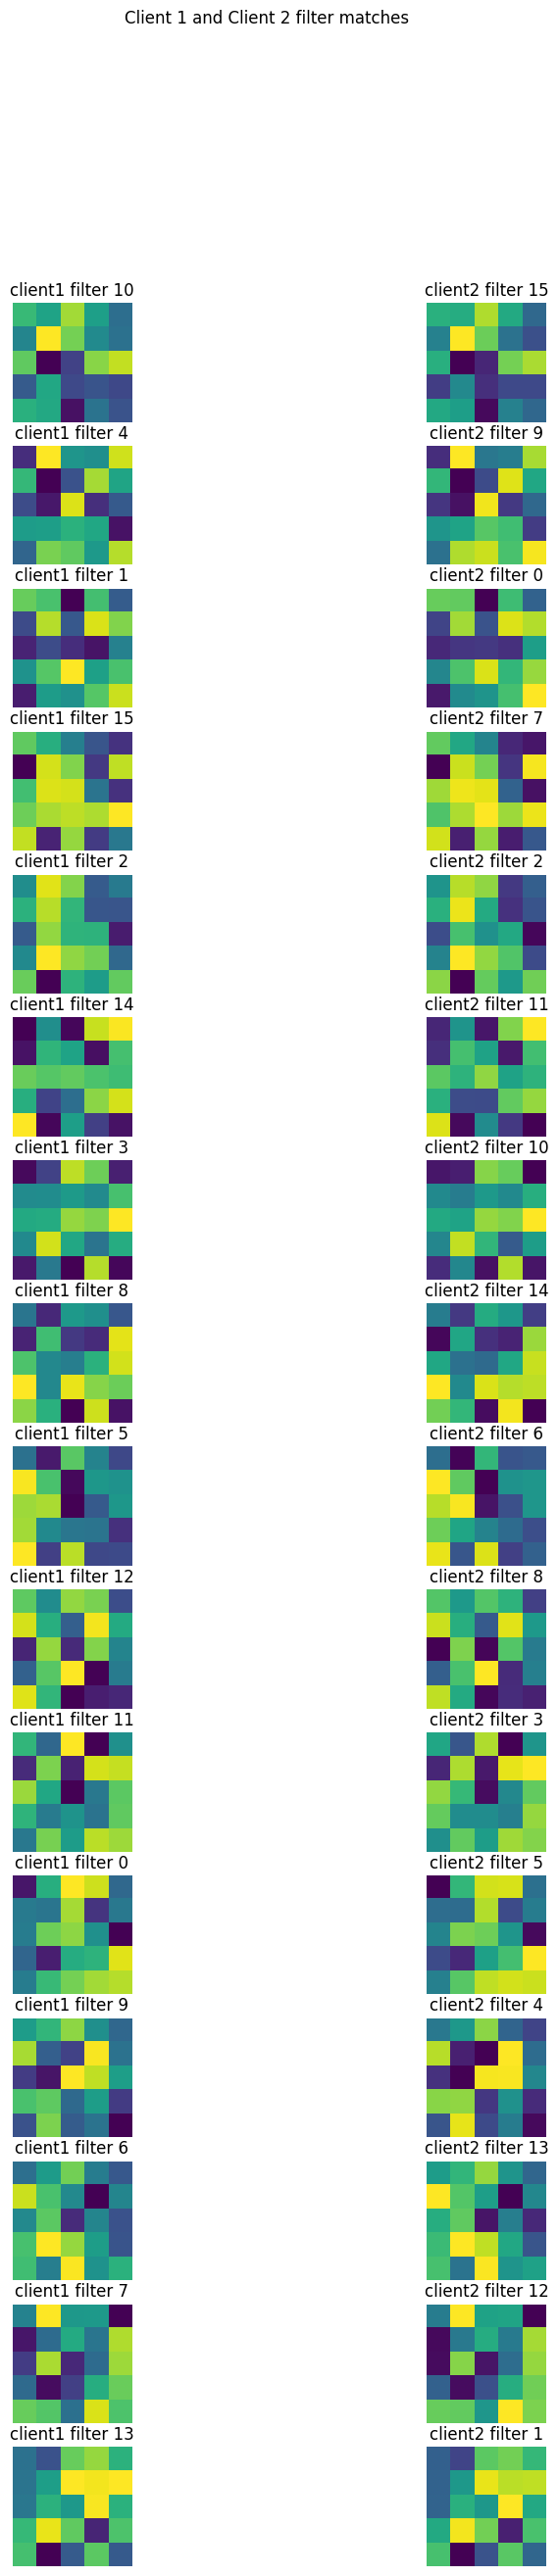

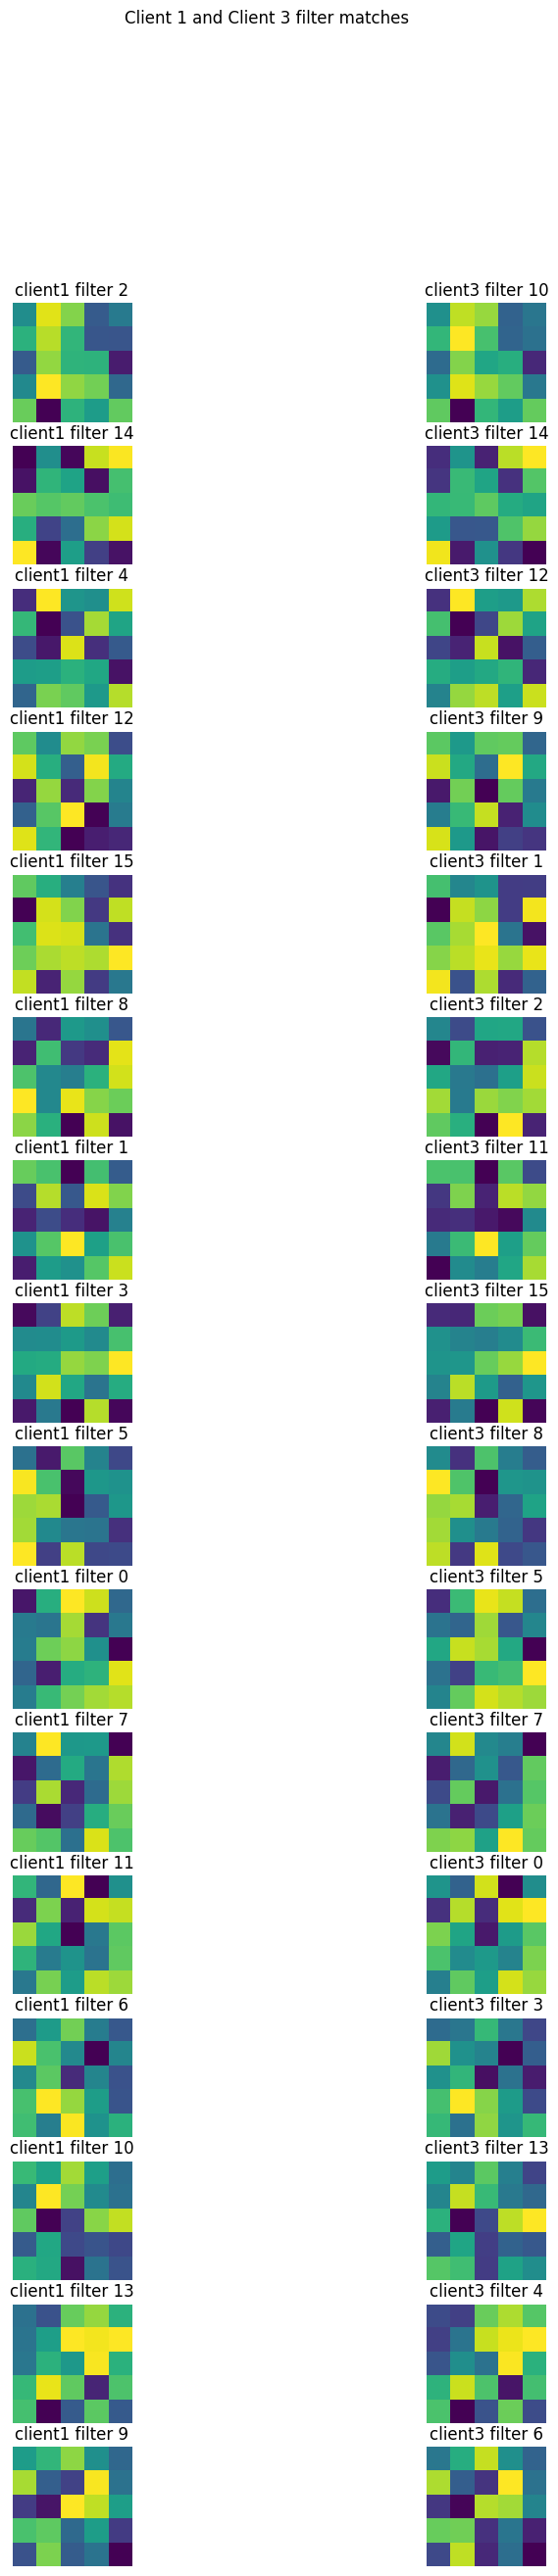

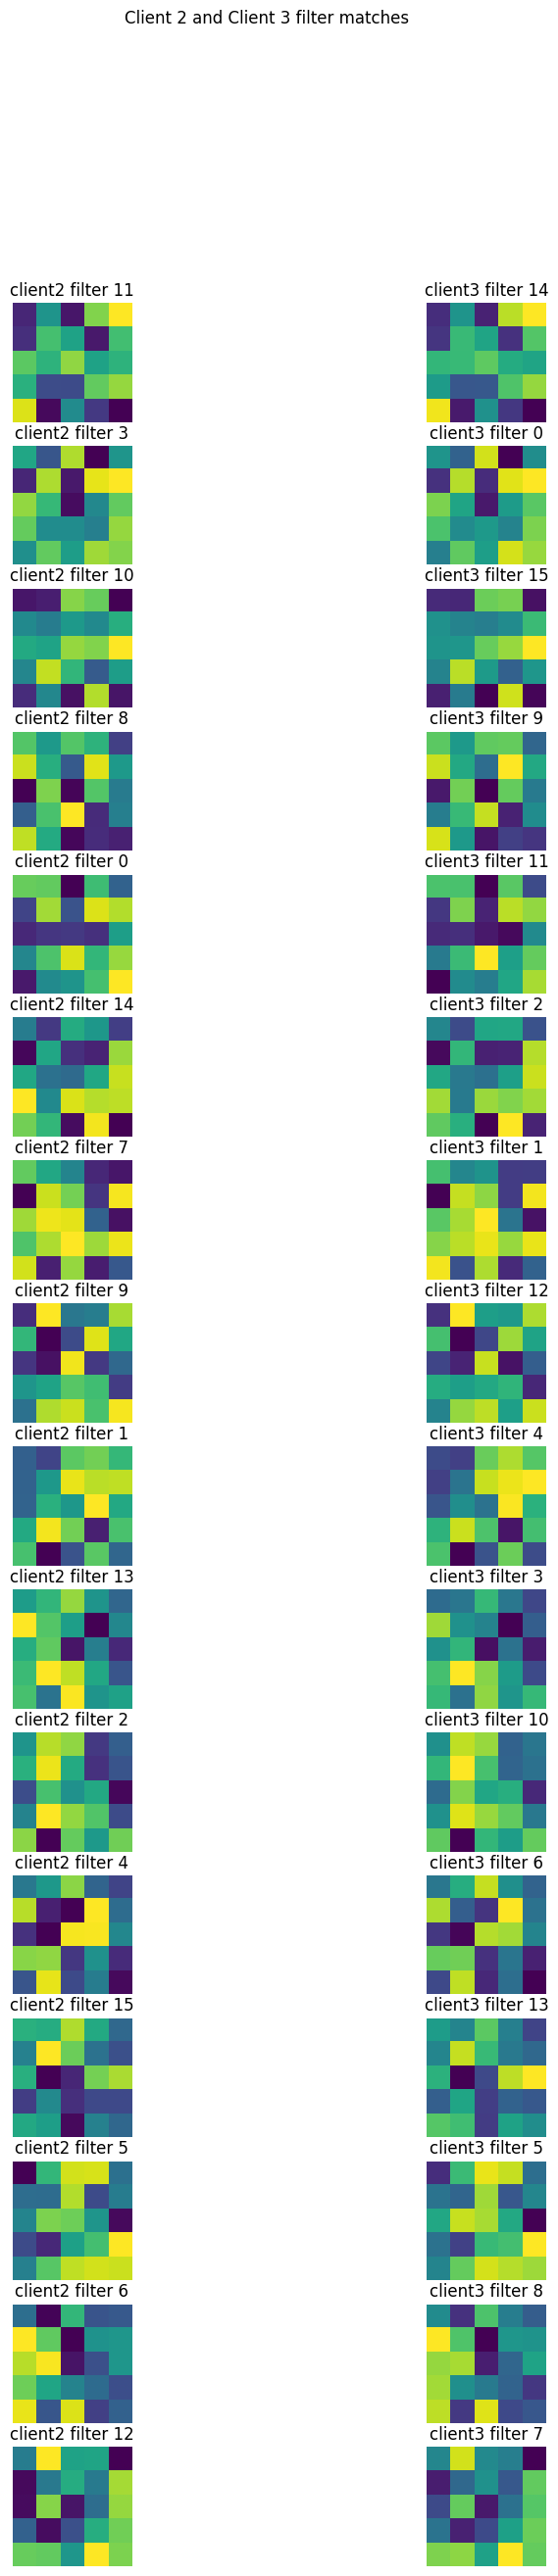

In [22]:
# plot the filter matches
matches_12 = match_filters(compute_filter_dist(client1_filters, client2_filters))
matches_13 = match_filters(compute_filter_dist(client1_filters, client3_filters))
matches_23 = match_filters(compute_filter_dist(client2_filters, client3_filters))
fig, axs = plt.subplots(len(matches_12), 2, figsize=(10, 30))
for i, (match12, match23) in enumerate(zip(matches_12, matches_23)):
    filter1, filter2, dist = match12
    axs[i, 0].imshow(client1_filters[filter1][0].detach().numpy())
    axs[i,0].set_title(f'client1 filter {filter1}')
    axs[i, 1].imshow(client2_filters[filter2][0].detach().numpy())
    axs[i,1].set_title(f'client2 filter {filter2}')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
fig.suptitle('Client 1 and Client 2 filter matches')    
plt.show()

fig, axs = plt.subplots(len(matches_13), 2, figsize=(10, 30))
for i, (match13, match23) in enumerate(zip(matches_13, matches_23)):
    filter1, filter2, dist = match13
    axs[i, 0].imshow(client1_filters[filter1][0].detach().numpy())
    axs[i,0].set_title(f'client1 filter {filter1}')
    axs[i, 1].imshow(client3_filters[filter2][0].detach().numpy())
    axs[i,1].set_title(f'client3 filter {filter2}')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
fig.suptitle('Client 1 and Client 3 filter matches')
plt.show()

fig, axs = plt.subplots(len(matches_23), 2, figsize=(10, 30))
for i, (match23, match23) in enumerate(zip(matches_23, matches_23)):
    filter1, filter2, dist = match23
    axs[i, 0].imshow(client2_filters[filter1][0].detach().numpy())
    axs[i,0].set_title(f'client2 filter {filter1}')
    axs[i, 1].imshow(client3_filters[filter2][0].detach().numpy())
    axs[i,1].set_title(f'client3 filter {filter2}')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
fig.suptitle('Client 2 and Client 3 filter matches')
plt.show()


In [3]:
from server import Server
import yaml
import random
from aggregation.strategies import load_aggregator
from experiment_runner import set_global_seed


aggregator = load_aggregator('fedavg')

In [19]:
from experiment_runner import FLNetwork

yaml_path = "config.yaml"
with open(yaml_path, "r") as f:
    config = yaml.safe_load(f)
print("Loaded config")
print(config)
config['task'] = 'cifar10'
config['initial_epochs'] = 1

fl_net = FLNetwork(config)
client_models = fl_net.server.initial_cluster_rounds(return_models=True)

Loaded config
{'description': 'baseline (wholenetwork ave). mnist, 2 clusters rotated', 'clients': 10, 'num_clusters': 2, 'num_rounds': 50, 'local_epochs': 1, 'train_sample_rate': 1.0, 'initial_epochs': 0, 'evaluation_sampling_rate': 1.0, 'task': 'mnist', 'aggregator': 'fedavg', 'lr': 0.01, 'cluster_split_type': 'rotation', 'baseline_avg_whole_network': True, 'cluster': 'kmeans', 'cluster_params': {'k_iter': 10, 'filter_distance': 'max'}, 'random_seed': 322}
Files already downloaded and verified
Files already downloaded and verified
Client 0 initialized on device:  cuda:0
Client 1 initialized on device:  cuda:0
Client 2 initialized on device:  cuda:0
Client 3 initialized on device:  cuda:0
Client 4 initialized on device:  cuda:0
Client 5 initialized on device:  cuda:0
Client 6 initialized on device:  cuda:0
Client 7 initialized on device:  cuda:0
Client 8 initialized on device:  cuda:0
Client 9 initialized on device:  cuda:0
Cluster 0 has 5 clients
client 0 train start 0 end 9999      

/home/siddhartha/clusterFL/utils.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Client 0 epoch 0 loss: 2.284209793748947
Client 0 finished training
Training client 1 cluster 1
Client 1 epoch 0 loss: 2.289810735196732
Client 1 finished training
Training client 2 cluster 0
Client 2 epoch 0 loss: 2.2852966991095496
Client 2 finished training
Training client 3 cluster 1
Client 3 epoch 0 loss: 2.2890736226456614
Client 3 finished training
Training client 4 cluster 0
Client 4 epoch 0 loss: 2.281881660699083
Client 4 finished training
Training client 5 cluster 1
Client 5 epoch 0 loss: 2.2888895604557122
Client 5 finished training
Training client 6 cluster 0
Client 6 epoch 0 loss: 2.2881260382862516
Client 6 finished training
Training client 7 cluster 1
Client 7 epoch 0 loss: 2.291546890910822
Client 7 finished training
Training client 8 cluster 0
Client 8 epoch 0 loss: 2.284326801665675
Client 8 finished training
Training client 9 cluster 1
Client 9 epoch 0 loss: 2.293038602835073
Client 9 finished training
Cluster 0 estimated assignments: [1, 3, 5, 7, 9]
Cluster 1 estim

In [ ]:
def get_cluster_and_dists(state_dicts):
    clusterList = [[] for i in range(2)]
    clients = [i for i in range(len(state_dicts))]

    # Assign intial centroids
    for clus in clusterList:
        randK = random.choice(clients)
        clus.append(randK)
        clients.remove(randK)

    # Calculate each clients distance from the centroid node
    weights =  state_dicts
    # print(type(weights[]))
    firstPass = True
    for i in range(10):
        distanceMap = {}
        for client in clients:
            distanceMap[client] = []
            for clus in clusterList:
                dist = 0
                for layer, tensor in weights[client].items():
                    dist += torch.abs(
                        tensor
                        - (weights[clus[0]][layer] if firstPass else clus[0][layer])
                    ).sum()
                distanceMap[client].append(dist)

        # Assign each cluster to the closest centroid
        for client, distances in distanceMap.items():
            clusterList[distances.index(min(distances))].append(client)

        # Reset Clients
        if i + 1 == 10:
            for clus in clusterList:
                clus.pop(0)
        else:
            clients = [j for j in range(len(state_dicts))]
            centroids = []
            for clus in clusterList:
                if not firstPass:
                    clus.pop(0)
                centroids.append(
                    aggregator.aggregate(
                        [state_dicts[client] for client in clus]
                    )
                )
            clusterList = [[centroid] for centroid in centroids]
            firstPass = False
    return distanceMap, clusterList

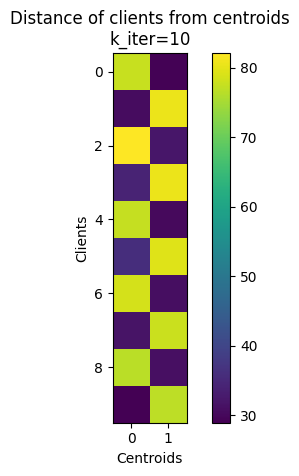

In [ ]:
dist_map, cluster_list = get_cluster_and_dists([client_model[1] for client_model in client_models])
dist_mat_np = np.zeros((len(dist_map), 2))
for client, dists in dist_map.items():
    
    dists = [dist.item() for dist in dists]
    dist_mat_np[client-2, :] = dists

plt.imshow(dist_mat_np)
plt.colorbar()
plt.title("Distance of clients from centroids\nk_iter=10")
plt.xlabel("Centroids")
plt.ylabel("Clients")
plt.show()

/home/siddhartha/clusterFL/venv_cluster/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


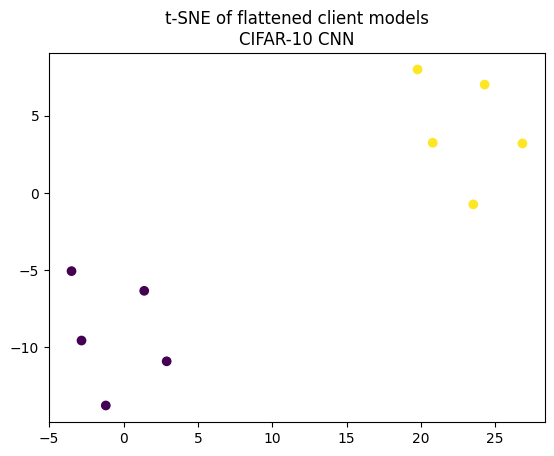

In [ ]:
# tsne
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=5, n_iter=4000)
client_ids = [client_model[0] for client_model in client_models]
models = [client_model[1] for client_model in client_models]
# flatten each  state dict
for i in range(len(models)):
    flattened = []
    for layer, tensor in models[i].items():
        flattened.append(tensor.flatten())
    models[i] = torch.cat(flattened)

models = torch.stack(models)
tsne_models = tsne.fit_transform(models.cpu().detach().numpy())

# plot. labels are client id % 2
plt.scatter(tsne_models[:,0], tsne_models[:,1], c=[client_id%2 for client_id in client_ids])
plt.title("t-SNE of flattened client models\nCIFAR-10 CNN")
plt.show()


In [ ]:

class FLNetwork:
    def __init__(self, config):
        self.config = config
        self.num_clients = config["clients"]
        self.num_clusters = config["num_clusters"]
        set_global_seed(config['random_seed'])
        self.server = Server(config, experiment_id='null', random_seed=config['random_seed'])
        
    def run(self):
        initial_epochs_range = range(1)
        state_dicts = [[] for _ in range(self.num_clients)]
        for client in self.server.clients:
            client_train_loader, _ = self.server.get_client_data(client.id, batch_size=32)
            client_model = load_model(self.config["task"])
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.SGD(client_model.parameters(), lr=self.server.lr)
            for i in initial_epochs_range:
                client_model = client.train(client_model, client_train_loader, criterion, optimizer, num_epochs=1)
                state_dicts[client.id].append((i, client_model.state_dict()))

        # self.state_dicts = state_dicts
        # dist_mat = np.zeros((self.num_clients, self.num_clients))
        # model = load_model(self.config["model"])
        # for i in range(self.num_clients):
        #     client1_model = state_dicts[i][-1][1]
        #     model.load_state_dict(client1_model)
        #     for j in range(i+1, self.num_clients):
        #         # evaluate client2 using client1's model
        #         _, client2_test_loader = self.server.get_client_data(j, batch_size=32)
        #         firstbatchonly = [next(iter(client2_test_loader))]
        #         acc,loss = self.server.clients[j].evaluate(model, firstbatchonly, nn.CrossEntropyLoss())
        #         dist_mat[i, j] = loss
        #         dist_mat[j, i] = loss
        # self.dist_mat = dist_mat
        # print(dist_mat)

In [9]:
config = yaml.load(open('config.yaml', 'r'), Loader=yaml.FullLoader)
fl = FLNetwork(config)
results =fl.run()

Files already downloaded and verified
Files already downloaded and verified
Client 0 initialized on device:  cuda:0
Client 1 initialized on device:  cuda:0
Client 2 initialized on device:  cuda:0
Client 3 initialized on device:  cuda:0
Client 4 initialized on device:  cuda:0
Client 5 initialized on device:  cuda:0
Client 6 initialized on device:  cuda:0
Client 7 initialized on device:  cuda:0
Client 8 initialized on device:  cuda:0
Client 9 initialized on device:  cuda:0
Cluster 0 has 5 clients
client 0 train start 0 end 9999                         on dataset 0. Device cuda:0
client 2 train start 10000 end 19999                         on dataset 0. Device cuda:0
client 4 train start 20000 end 29999                         on dataset 0. Device cuda:0
client 6 train start 30000 end 39999                         on dataset 0. Device cuda:0
client 8 train start 40000 end 49999                         on dataset 0. Device cuda:0
Cluster 1 has 5 clients
client 1 train start 0 end 9999     

In [11]:
cluster_list, dist_map = results

cluster_list

[[1, 2, 3, 8, 9], [0, 4, 5, 6, 7]]

In [10]:
# visualize distance map
# dist map is a dictionary of client id to list of distances to each clusters
cluster_list, dist_map = results
dist_mat_np = np.zeros((len(results), 2))
print(results.keys())
for client, dists in dist_map.items():
    
    dists = [dist.item() for dist in dists]
    dist_mat_np[client-2, :] = dists

plt.imshow(dist_mat_np)
plt.colorbar()
plt.show()

    

AttributeError: 'tuple' object has no attribute 'keys'

In [189]:

server_proxy_train, server_proxy_test = load_global_dataset('cifar10')
server_proxy_test = create_clustered_dataset(server_proxy_test, 4, 'rotation')[-1]
server_proxy_loader = DataLoader(server_proxy_test, batch_size=32, shuffle=True)
fl.server.proxy_data = server_proxy_loader   

Files already downloaded and verified
Files already downloaded and verified


In [97]:
from sklearn.cluster import SpectralClustering

In [209]:
'''[[0.     0.2465 0.35   0.239  0.3395 0.2375 0.3455 0.2465 0.338  0.25  ]
 [0.2465 0.     0.237  0.347  0.2295 0.3455 0.2415 0.3455 0.2325 0.3505]
 [0.35   0.237  0.     0.236  0.3795 0.2355 0.375  0.2375 0.3765 0.236 ]
 [0.239  0.347  0.236  0.     0.242  0.397  0.25   0.4    0.222  0.4095]
 [0.3395 0.2295 0.3795 0.242  0.     0.2225 0.3725 0.2265 0.392  0.2265]
 [0.2375 0.3455 0.2355 0.397  0.2225 0.     0.233  0.3795 0.2325 0.3925]
 [0.3455 0.2415 0.375  0.25   0.3725 0.233  0.     0.2545 0.3845 0.2485]
 [0.2465 0.3455 0.2375 0.4    0.2265 0.3795 0.2545 0.     0.2535 0.409 ]
 [0.338  0.2325 0.3765 0.222  0.392  0.2325 0.3845 0.2535 0.     0.22  ]
 [0.25   0.3505 0.236  0.4095 0.2265 0.3925 0.2485 0.409  0.22   0.    ]]'''
dist_mat = np.array([[0.     ,0.2465, 0.35   ,0.239 , 0.3395, 0.2375, 0.3455, 0.2465, 0.338 , 0.25  ],
    [0.2465, 0.     ,0.237 , 0.347 , 0.2295, 0.3455, 0.2415, 0.3455, 0.2325, 0.3505],
    [0.35   , 0.237 , 0.     ,0.236 , 0.3795, 0.2355, 0.375 , 0.2375, 0.3765, 0.236 ],
    [0.239 , 0.347 , 0.236 , 0.     ,0.242 , 0.397 , 0.25  , 0.4   , 0.222 , 0.4095],
    [0.3395, 0.2295, 0.3795, 0.242 , 0.     , 0.2225, 0.3725, 0.2265, 0.392 , 0.2265],
    [0.2375, 0.3455, 0.2355, 0.397 , 0.2225, 0.     , 0.233 , 0.3795, 0.2325, 0.3925],
    [0.3455, 0.2415, 0.375 , 0.25  , 0.3725, 0.233 , 0.     , 0.2545, 0.3845, 0.2485],
    [0.2465, 0.3455, 0.2375, 0.4   , 0.2265, 0.3795, 0.2545, 0.     , 0.2535, 0.409 ],
    [0.338 , 0.2325, 0.3765, 0.222 , 0.392 , 0.2325, 0.3845, 0.2535, 0.     , 0.22  ],
    [0.25  , 0.3505, 0.236 , 0.4095, 0.2265, 0.3925, 0.2485, 0.409 , 0.22  , 0.    ]])

# normalize the distance matrix
dist_mat = dist_mat / np.max(dist_mat)
sc = SpectralClustering(n_clusters=2, affinity='precomputed', random_state = np.random.randint(100))
km = sc.fit(dist_mat)
cluster_assignment = km.labels_
clusters = [[] for _ in range(2)]   
for i, cluster in enumerate(cluster_assignment):
    clusters[cluster].append(i)
clusters

[[0, 2, 4, 6, 8], [1, 3, 5, 7, 9]]

In [122]:
'''
onebatchonly
[[0.      0.25    0.25    0.21875 0.3125  0.15625 0.28125 0.34375 0.4375  0.375  ]
 [0.25    0.      0.21875 0.34375 0.21875 0.25    0.3125  0.21875 0.3125 0.53125]
 [0.25    0.21875 0.      0.3125  0.375   0.15625 0.375   0.15625 0.40625 0.25   ]
 [0.21875 0.34375 0.3125  0.      0.15625 0.40625 0.25    0.4375  0.21875 0.4375 ]
 [0.3125  0.21875 0.375   0.15625 0.      0.25    0.40625 0.25    0.4375 0.25   ]
 [0.15625 0.25    0.15625 0.40625 0.25    0.      0.1875  0.25    0.25 0.4375 ]
 [0.28125 0.3125  0.375   0.25    0.40625 0.1875  0.      0.28125 0.375 0.28125]
 [0.34375 0.21875 0.15625 0.4375  0.25    0.25    0.28125 0.      0.25 0.40625]
 [0.4375  0.3125  0.40625 0.21875 0.4375  0.25    0.375   0.25    0. 0.28125]
 [0.375   0.53125 0.25    0.4375  0.25    0.4375  0.28125 0.40625 0.28125 0.     ]]
  '''
dist_mat = np.array([[0.      ,0.25    ,0.25    ,0.21875 ,0.3125  ,0.15625 ,0.28125 ,0.34375 ,0.4375  ,0.375  ],
    [0.25    ,0.      ,0.21875 ,0.34375 ,0.21875 ,0.25    ,0.3125  ,0.21875 ,0.3125  ,0.53125],
    [0.25    ,0.21875 ,0.      ,0.3125  ,0.375   ,0.15625 ,0.375   ,0.15625 ,0.40625 ,0.25   ],
    [0.21875 ,0.34375 ,0.3125  ,0.      ,0.15625 ,0.40625 ,0.25    ,0.4375  ,0.21875 ,0.4375 ],
    [0.3125  ,0.21875 ,0.375   ,0.15625 ,0.      ,0.25    ,0.40625 ,0.25    ,0.4375  ,0.25   ],
    [0.15625 ,0.25    ,0.15625 ,0.40625 ,0.25    ,0.      ,0.1875  ,0.25    ,0.25    ,0.4375 ],
    [0.28125 ,0.3125  ,0.375   ,0.25    ,0.40625 ,0.1875  ,0.      ,0.28125 ,0.375   ,0.28125],
    [0.34375 ,0.21875 ,0.15625 ,0.4375  ,0.25    ,0.25    ,0.28125 ,0.      ,0.25    ,0.40625],
    [0.4375  ,0.3125  ,0.40625 ,0.21875 ,0.4375  ,0.25    ,0.375   ,0.25    ,0.      ,0.28125],
    [0.375   ,0.53125 ,0.25    ,0.437 , 0.25    ,0.4375  ,0.28125 ,0.40625 ,0.28125 ,0.     ]])
dist_mat = dist_mat / np.max(dist_mat)
sc = SpectralClustering(n_clusters=2, affinity='precomputed', random_state = np.random.randint(100))
km = sc.fit(dist_mat)
cluster_assignment = km.labels_
clusters = [[] for _ in range(2)]   
for i, cluster in enumerate(cluster_assignment):
    clusters[cluster].append(i)
clusters

/home/siddhartha/clusterFL/venv_cluster/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:310: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


[[1, 3, 5, 7, 9], [0, 2, 4, 6, 8]]

In [ ]:
# get outputs of all clients models on proxy data
client_outputs = []
model = load_model('cifarcnn')
for i,client in enumerate(fl.server.clients):
    model.load_state_dict(fl.state_dicts[i][-1][1])
    

In [3]:
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

In [116]:
state_dicts = torch.load('experiments/clients_upto_10_epochs.pth')
def cluster_purity(cluster_labels, true_clusters):
    '''
    Compute the purity of the clusters. for each predicted cluster, the purity is higher if the majority of the samples
    in the cluster belong to the same true cluster.

    return the weighted mean of the cluster purities, where the weights are the number of samples in each cluster.
    Args:
        cluster_labels: estimated cluster label for each client
        true_clusters: unordered list of true cluster assignments
    Returns:
        purity: the purity of the clusters. 
    '''
    cluster_purities = []
    for true_cluster in true_clusters:
        cluster_purity = []
        for cluster in set(cluster_labels):
            cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster]
            true_cluster_count = sum([1 for i in cluster_indices if i in true_cluster])
            cluster_purity.append(true_cluster_count/len(cluster_indices))
        cluster_purities.append(max(cluster_purity))
    return np.mean(cluster_purities)
for num_epochs in range(len(state_dicts[0])):
    client_state_dicts = [state_dict[num_epochs][1] for state_dict in state_dicts]
    weights = [list(state_dict['nn.0.weight']) for state_dict in client_state_dicts]
    dist_mat = max_matching_dist(weights)
    km = SpectralClustering(2)
    km.fit(dist_mat) # -> example: [0, 0, 0, 1, 1, 1, 0, 0, 0, 1]
    clients_to_clusters = [[] for _ in range(2)]
    for i, cluster in enumerate(km.labels_):
        clients_to_clusters[cluster].append(i)
    print(clients_to_clusters   )

/tmp/ipykernel_50757/4219676356.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dicts = torch.load('experiments/clients_upto_10_epochs.pth')
/home/siddhartha/clust

[[0, 1, 2, 6, 7, 8], [3, 4, 5, 9]]


/home/siddhartha/clusterFL/venv_cluster/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


[[0, 1, 2, 6, 7, 8], [3, 4, 5, 9]]


/home/siddhartha/clusterFL/venv_cluster/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


[[0, 1, 2, 6, 7, 8], [3, 4, 5, 9]]


/home/siddhartha/clusterFL/venv_cluster/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


[[0, 1, 2, 6, 7, 8], [3, 4, 5, 9]]


/home/siddhartha/clusterFL/venv_cluster/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


[[0, 1, 2, 6, 7, 8], [3, 4, 5, 9]]


/home/siddhartha/clusterFL/venv_cluster/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


[[3, 4, 5, 9], [0, 1, 2, 6, 7, 8]]


/home/siddhartha/clusterFL/venv_cluster/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


[[0, 1, 2, 6, 7, 8], [3, 4, 5, 9]]


/home/siddhartha/clusterFL/venv_cluster/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


[[0, 1, 2, 6, 7, 8], [3, 4, 5, 9]]


/home/siddhartha/clusterFL/venv_cluster/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


[[0, 1, 2, 6, 7, 8], [3, 4, 5, 9]]
[[0, 1, 2, 6, 7, 8], [3, 4, 5, 9]]


/home/siddhartha/clusterFL/venv_cluster/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


In [192]:
def get_feature_extraction(feature_extractor, dataloader):
    criterion = nn.CrossEntropyLoss()
    feature_extractor.eval()
    feature_extractor.to('cuda')
    losses = []
    features = []
    for i, (x, y) in enumerate(dataloader):
        if i > 5:
            break
        x, y = x.to('cuda'), y.to('cuda')
        with torch.no_grad():
            output = feature_extractor(x)
            loss = criterion(output, y)
            losses.append(loss.item())
            features.append(output)
    return features, losses

In [206]:
for num_epochs in range(len(state_dicts[0])):
    client_state_dicts = [state_dict[num_epochs][1] for state_dict in state_dicts]
    activations = []
    losses = []
    model = load_model('cifarcnn')
    for i, client_state_dict in enumerate(client_state_dicts): 
        # client_state_dict = {k.replace('nn.', ''): v for k, v in client_state_dict.items() if int(k.split('.')[1][:2]) < len(feature_extractor)}
        model.load_state_dict(client_state_dict)
        model.eval()
        feats, loss_list = get_feature_extraction(model, fl.server.proxy_data)
        activations.append(feats[0][0].cpu().numpy())
        losses.append([torch.mean(torch.tensor(loss_list)).item()])
        # print("Client", i, "loss:", losses[-1]) 
    sc = KMeans(2)
    losses = np.array(losses)
    km = sc.fit(losses)
    clients_to_clusters = [[] for _ in range(2)]
    for i, cluster in enumerate(km.labels_):
        clients_to_clusters[cluster].append(i)
    print(clients_to_clusters)

[[1, 2, 6, 7], [0, 3, 4, 5, 8, 9]]
[[0, 2, 3, 4, 7, 9], [1, 5, 6, 8]]
[[0, 1, 4, 7], [2, 3, 5, 6, 8, 9]]
[[3, 6, 8], [0, 1, 2, 4, 5, 7, 9]]
[[0, 1, 6, 7, 9], [2, 3, 4, 5, 8]]
[[0, 2, 6, 9], [1, 3, 4, 5, 7, 8]]
[[3, 4], [0, 1, 2, 5, 6, 7, 8, 9]]
[[6, 7, 9], [0, 1, 2, 3, 4, 5, 8]]
[[0, 1, 3, 4, 5, 6, 7, 9], [2, 8]]
[[0, 1, 5, 6, 7], [2, 3, 4, 8, 9]]
